# Deep Learning $for$ Book Recommending System
This is a project on a Recommendation system that suggest different books to users based on their past behavior i.e., likings and ratings.
## About the dataset:
The Book-Crossing dataset can be found on the following website:

http://www2.informatik.uni-freiburg.de/~cziegler/BX/

This dataset is a collaborative filtering dataset and contains information about users, books, and ratings. It was collected by Cai-Nicolas Ziegler in a 4-week crawl (August / September 2004) from the Book-Crossing community, and contains 278,858 users (anonymized) providing 1,149,780 ratings (explicit / implicit) about 271,379 books.

## Load all necessary libraries
This section is about importing all libraries that will make the project walkthrough a success without an error.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load the datasets into this workspace

In [ ]:
ratings = pd.read_csv("/content/drive/MyDrive/Final year project/BX-Book-Ratings.csv", delimiter=";", on_bad_lines='skip', encoding='unicode_escape')
books = pd.read_csv("/content/drive/MyDrive/Final year project/BX-Books.csv", delimiter=";", on_bad_lines='skip', low_memory=False, encoding='unicode_escape')
users = pd.read_csv("/content/drive/MyDrive/Final year project/BX-Users.csv", delimiter=";", on_bad_lines='skip', encoding='unicode_escape')

## Data Exploration

### Book Ratings
To get the glimpse of the dataset, I will show the top 3 rows of the book ratings dataset.

In [ ]:
ratings.head(3)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0


* Brief information about different columns of the ratings dataframe:

In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


The `ISBN` (i.e., book-id) is represented as an object. What can causes this is non-numerical character in the ID. Also, from the above information it can be seen that the ratings table has no blank/null values.

In [ ]:
ratings.duplicated().any()

False

This confirms that the ratings dataframe has no duplicate values.

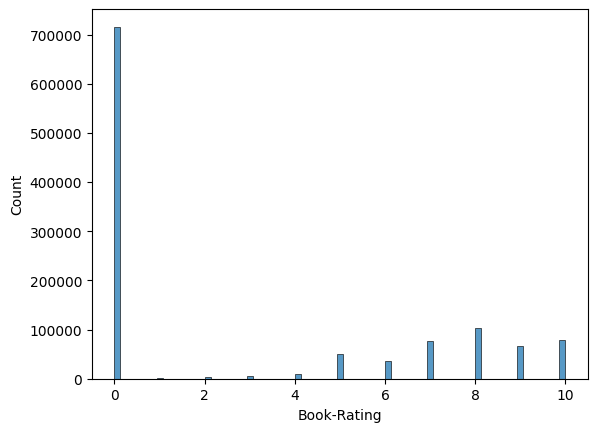

In [ ]:
sns.histplot(ratings, x='Book-Rating');

There seem to be more zeros (0) ratings in the book rated. Explicit ratings are what can contribute to the effectiveness of the model to be built, these zeros will serve as redundancy to the model.

### Book information
* Top 3 rows of the books information:

In [ ]:
books.head(3)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...


* Brief information about different columns of the books dataframe:

In [ ]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271356 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


The same is true for this dataset also i.e., `ISBN` column is represented as an object instead of an integer. One book author and two publisers are missing in the dataset.

In [ ]:
books.isna().any()

ISBN                   False
Book-Title             False
Book-Author             True
Year-Of-Publication    False
Publisher               True
Image-URL-S            False
Image-URL-M            False
Image-URL-L             True
dtype: bool

In the books table, three columns contain missing data i.e., `Book-Author`, `Publiser` and `Image-URL-L`.

In [ ]:
books.duplicated().any()

False

The books table has no duplicate values.

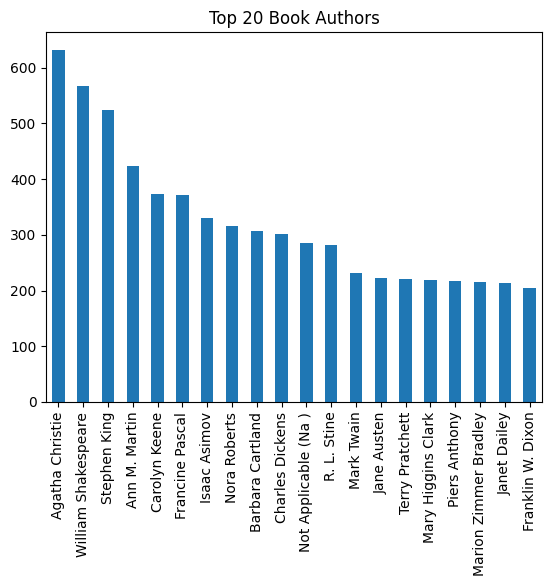

In [ ]:
books["Book-Author"].value_counts()[:20].plot.bar()
plt.title("Top 20 Book Authors");

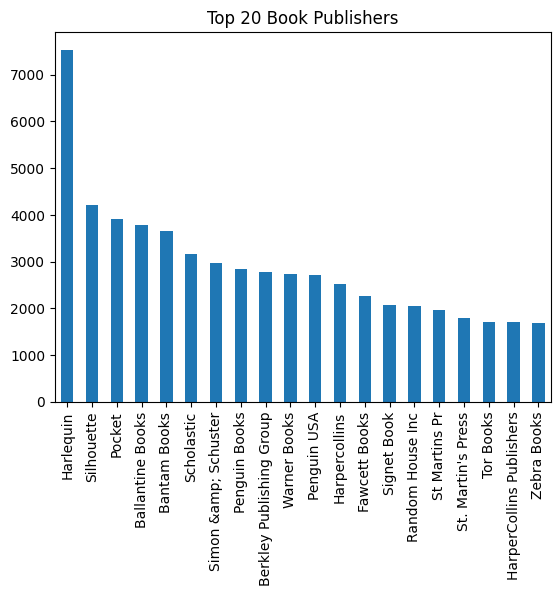

In [ ]:
books["Publisher"].value_counts()[:20].plot.bar()
plt.title("Top 20 Book Publishers");

### Users information
* Top 5 header lines of the users information

In [ ]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


Three attributes are in a column i.e., Location ["City", "State", "Country"]

* Brief information about different columns of the users dataframe:

In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


The age column seems to have many missing values.

In [ ]:
users[users["Age"].isna()].head(10)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
2,3,"moscow, yukon territory, russia",NaN
4,5,"farnborough, hants, united kingdom",NaN
6,7,"washington, dc, usa",NaN
7,8,"timmins, ontario, canada",NaN
8,9,"germantown, tennessee, usa",NaN
11,12,"fort bragg, california, usa",NaN
13,14,"mediapolis, iowa, usa",NaN
14,15,"calgary, alberta, canada",NaN
15,16,"albuquerque, new mexico, usa",NaN


In [ ]:
users["Age"].describe()

count    168096.000000
mean         34.751434
std          14.428097
min           0.000000
25%          24.000000
50%          32.000000
75%          44.000000
max         244.000000
Name: Age, dtype: float64

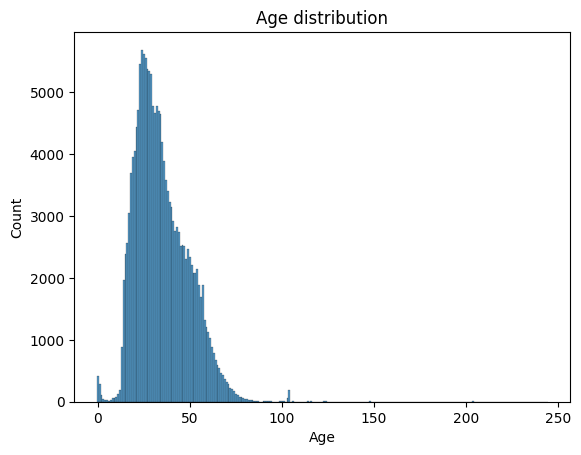

In [ ]:
# Distribution of the age of users

sns.histplot(users, x="Age", discrete=True)
plt.title("Age distribution");

There seem to be some few outliers in the age distribution.

In [ ]:
# Checking for duplicate
users.duplicated().any()

False

No duplicate entry is detected.

### GENERAL OBSERVATIONS:
- The three datasets have no duplicate entry, but some null entries were detected.
- The "books" dataframe contains some unnecessary columns which are not needed for this analysis e.g. `"Image-URL-S"`, `"Image-URL-M"`, `"Image-URL-L"` etc.
- Two books have no Publishers and one book has no Author which will not be needed for the analysis.
- Some wrong columns are assigned to the `"Year-Of-Publication"` in the `books` dataframe which makes it to be loaded as an `object` instead of an `integer`.
- `ISBN` column (i.e., the book-id) has been misrepresented due to some non numerical characters.
- The location column in the users dataset has three attributes (i.e., City, State and Country), placing these attributes in their right column will improve the data quality.
- The users age seems to have many outliers (i.e., values above 110), using imputation techniques to handle this will bring about consistency.
- Since we will be working with explicit ratings, ratings with the value of zero(0) will not be needed for the recommendation system to avoid redundancy.

## Data Cleaning
In this section, I will remove all the unnecessary columns and the invalid rows from the dataframe. Some user-id and book-id have unknown character which make them to be represented as an object. So, I will be using the LabelEncoder() function of the sklearn library to encode each and every id in the dataset to a numerical equivalent. But before that, I will remove all unknown ids in both User-ID and ISBN in the ratings dataframe.

* Drop all redundant columns from the books dataframe:

In [ ]:
# Drop unnecessary columns
books.drop(columns=['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], inplace=True)

- Remove all missing values in the books table

In [ ]:
books.dropna(inplace=True)

- Remove all zero ratings from the book dataset

In [ ]:
ratings = ratings[ratings["Book-Rating"]!=0]

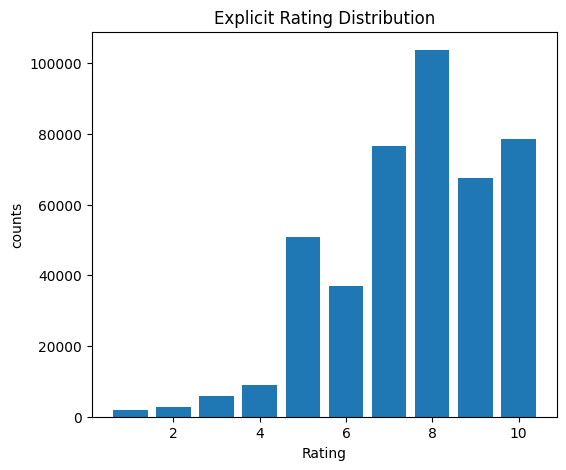

In [ ]:
rtg = ratings["Book-Rating"].value_counts().sort_index()

plt.figure(figsize=(6, 5))
plt.bar(rtg.index, rtg.values)
plt.xlabel('Rating')
plt.ylabel('counts')
plt.title('Explicit Rating Distribution');

- Expand the Location column in the user's table to improve the data quality

In [ ]:
users[["City", "State", "Country"]] = users["Location"].str.split(", ", n=2, expand=True)

users.loc[(users["State"]=='\\n/a\\"') | (users["State"]=='') | (users["State"]=='*') |
          (users["State"]=='n.a'), ['State']] = 'n/a'
users["State"].fillna('other', inplace=True)
users[["City", "State", "Country"]] = users.loc[:, ["City", "State", "Country"]
                                                ].apply(lambda cols: cols.str.title()).fillna('n/a')
users.drop("Location", axis=1, inplace=True)

users.head()

,User-ID,Age,City,State,Country
0,1,NaN,Nyc,New York,Usa
1,2,18.0,Stockton,California,Usa
2,3,NaN,Moscow,Yukon Territory,Russia
3,4,17.0,Porto,V.N.Gaia,Portugal
4,5,NaN,Farnborough,Hants,United Kingdom


- Handle all outliers in the age column

In [ ]:
# Imputation techniques will be used to handle these
users.loc[users['Age'] > 110, "Age"] = np.nan
users.loc[users['Age'] < 5, "Age"] = np.nan

- Perform imputation on the missing age

In [ ]:
temp_age_series = pd.Series(np.random.normal(loc=users["Age"].mean(), scale=users["Age"].std(),
                                              size=users["Age"].isna().values.sum())).abs()

In [ ]:
# Sort users table using age, make sure that missing values come first so as to replace them directly
users = users.sort_values('Age',na_position='first').reset_index(drop=True)
users["Age"].fillna(temp_age_series, inplace=True)
users.loc[users['Age'] < 5, "Age"] = users['Age'].mean()
users["Age"] = users["Age"].astype(int)

In [ ]:
users.head()

,User-ID,Age,City,State,Country
0,1,13,Nyc,New York,Usa
1,3,51,Moscow,Yukon Territory,Russia
2,5,29,Farnborough,Hants,United Kingdom
3,7,10,Washington,Dc,Usa
4,8,51,Timmins,Ontario,Canada


In [ ]:
users["Age"].describe()

count    278858.000000
mean         34.859118
std          13.609012
min           5.000000
25%          25.000000
50%          33.000000
75%          44.000000
max         110.000000
Name: Age, dtype: float64

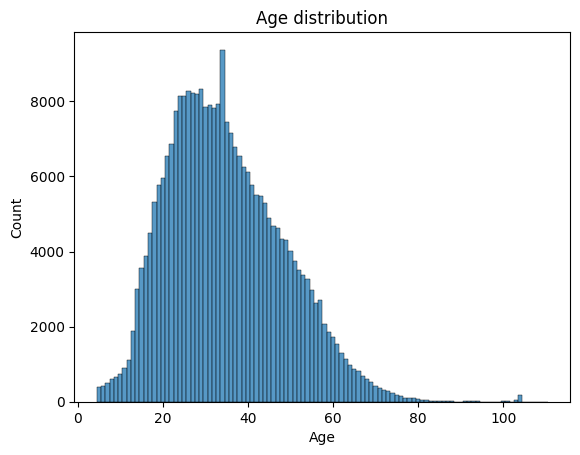

In [ ]:
# Distribution of the age of users after outlier handliing

sns.histplot(users, x="Age", discrete=True)
plt.title("Age distribution");

In [ ]:
users.head()

,User-ID,Age,City,State,Country
0,1,13,Nyc,New York,Usa
1,3,51,Moscow,Yukon Territory,Russia
2,5,29,Farnborough,Hants,United Kingdom
3,7,10,Washington,Dc,Usa
4,8,51,Timmins,Ontario,Canada


* Remove rows with id that are not in the books and users dataframe:

In [ ]:
ratings = ratings[ratings['ISBN'].isin(books['ISBN'].values)]
ratings = ratings[ratings['User-ID'].isin(users['User-ID'].values)]

* Transform all IDs to integer equivalent using LabelEncoder

In [ ]:
# Transform both the user and the book IDs
isbn_transformer = LabelEncoder().fit(books['ISBN'])
books['ISBN'] = isbn_transformer.transform(books['ISBN'])
ratings['ISBN'] = isbn_transformer.transform(ratings['ISBN'])

userid_transformer = LabelEncoder().fit(users['User-ID'])
users['User-ID'] = userid_transformer.transform(users['User-ID'])
ratings['User-ID'] = userid_transformer.transform(ratings['User-ID'])

## Brief overview of dataframes after data cleaning

#### Ratings

In [ ]:
ratings.head()

,User-ID,ISBN,Book-Rating
1,276725,22827,5
3,276728,111840,3
4,276728,111874,6
8,276743,70983,7
16,276746,5734,9


In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383839 entries, 1 to 1149778
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   User-ID      383839 non-null  int64
 1   ISBN         383839 non-null  int64
 2   Book-Rating  383839 non-null  int64
dtypes: int64(3)
memory usage: 11.7 MB


#### Books

In [ ]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,25028,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,73,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,8211,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,60198,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,71711,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [ ]:
books.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271357 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271357 non-null  int64 
 1   Book-Title           271357 non-null  object
 2   Book-Author          271357 non-null  object
 3   Year-Of-Publication  271357 non-null  object
 4   Publisher            271357 non-null  object
dtypes: int64(1), object(4)
memory usage: 12.4+ MB


#### Users

In [ ]:
users.head()

,User-ID,Age,City,State,Country
0,0,13,Nyc,New York,Usa
1,2,51,Moscow,Yukon Territory,Russia
2,4,29,Farnborough,Hants,United Kingdom
3,6,10,Washington,Dc,Usa
4,7,51,Timmins,Ontario,Canada


In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   User-ID  278858 non-null  int64 
 1   Age      278858 non-null  int64 
 2   City     278858 non-null  object
 3   State    278858 non-null  object
 4   Country  278858 non-null  object
dtypes: int64(2), object(3)
memory usage: 10.6+ MB


## Recommendation Systems

In this section, I will be building a recommendation system. But before then, I will create a traininig and testing set to test the performance of my model. The library that can help in the splitting of the dataset into training and testing set is `train_test_split()` function of sklearn library.

In [ ]:
from sklearn.model_selection import train_test_split

# Split the ratings dataset into training and testing set for the subsequent data modelling
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

### Collaborative Filtering

The surprise library SVD class will be used to model the collaborative filtering. But before then, the dataset needs to be transformed to the format recognized by the package using the `Dataset` class.

In [ ]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split, cross_validate
from surprise import SVD
from surprise import accuracy

In [ ]:
# Load your dataset
reader = Reader(rating_scale=(1, 10))  # Define the rating scale
data = Dataset.load_from_df(ratings, reader)

In [ ]:
# Split the data into train and test sets (80% train, 20% test)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
# Create and train an SVD-based collaborative filtering model
model = SVD()
cross_validate(model, data, measures=['MAE', 'MSE', 'RMSE'], cv=5, verbose=True)

Evaluating MAE, MSE, RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     1.2619  1.2590  1.2659  1.2654  1.2635  1.2631  0.0025  
MSE (testset)     2.6628  2.6701  2.6953  2.6826  2.6827  2.6787  0.0112  
RMSE (testset)    1.6318  1.6340  1.6417  1.6379  1.6379  1.6367  0.0034  
Fit time          12.05   12.25   11.65   12.10   11.95   12.00   0.20    
Test time         0.59    0.66    0.58    1.85    1.93    1.12    0.63    


{'test_mae': array([1.26188644, 1.25896462, 1.2659492 , 1.2654101 , 1.26346908]),
 'test_mse': array([2.66279373, 2.67007038, 2.6952509 , 2.68258229, 2.68271732]),
 'test_rmse': array([1.63180689, 1.634035  , 1.64172193, 1.63785906, 1.63790028]),
 'fit_time': (12.051353931427002,
  12.251026391983032,
  11.650428533554077,
  12.099189758300781,
  11.946785926818848),
 'test_time': (0.585745096206665,
  0.661419153213501,
  0.5780510902404785,
  1.8503267765045166,
  1.9309287071228027)}

In [ ]:
predictions = model.test(testset)

In [ ]:
predictions[:4]

[Prediction(uid=212327, iid=115329, r_ui=10.0, est=7.825676142914408, details={'was_impossible': False}),
 Prediction(uid=210586, iid=71088, r_ui=5.0, est=6.415469986002402, details={'was_impossible': False}),
 Prediction(uid=227160, iid=84142, r_ui=10.0, est=7.090530056082188, details={'was_impossible': False}),
 Prediction(uid=179977, iid=164261, r_ui=10.0, est=8.71409636380701, details={'was_impossible': False})]

In [ ]:
performance = pd.DataFrame([["SVD_CF", accuracy.rmse(predictions, verbose=False),
                                 accuracy.mse(predictions, verbose=False), accuracy.mae(predictions, verbose=False)]],
                                  columns=["RSM", "RMSE", "MSE", "MAE"], )

performance

,RSM,RMSE,MSE,MAE
0,SVD_CF,1.152134,1.327414,0.863345


### Autoencoder

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error

# Define the number of unique users and items
num_users = len(users["User-ID"])
num_items = len(books["ISBN"])

# Autoencoder architecture
latent_dim = 64  # Increased latent dimension
# Input layers for user and item
user_input = Input(shape=(1,))
item_input = Input(shape=(1,))
# Embedding layers for user and item
user_embedding = Embedding(num_users, latent_dim)(user_input)
item_embedding = Embedding(num_items, latent_dim)(item_input)

# Flatten the embeddings
user_flat = Flatten()(user_embedding)
item_flat = Flatten()(item_embedding)

# Concatenate user and item embeddings
concatenated = Concatenate()([user_flat, item_flat])

# Encoder layers with dropout for regularization
encoder = Dense(128, activation='relu')(concatenated)
encoder = Dropout(0.2)(encoder)  # Dropout for regularization
encoder = Dense(64, activation='relu')(encoder)
encoder = Dropout(0.2)(encoder)

# Decoder layers
decoder = Dense(128, activation='relu')(encoder)
decoder = Dropout(0.2)(decoder)
decoder = Dense(64, activation='relu')(decoder)
# Output layer
output = Dense(1, activation='linear')(decoder)

# Create and compile the autoencoder model
autoencoder = Model(inputs=[user_input, item_input], outputs=output)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Train the autoencoder using the raw user-item interaction data
history = autoencoder.fit(x=[train_data['User-ID'], train_data['ISBN']], y=train_data['Book-Rating'],
                            validation_split=0.2, epochs=20, batch_size=128, verbose=2,  callbacks=[early_stopping])

Epoch 1/10
4798/4798 [==============================] - 2288s 477ms/step - loss: 3.1693
Epoch 2/10
4798/4798 [==============================] - 2230s 465ms/step - loss: 2.0091
Epoch 3/10
4798/4798 [==============================] - 2240s 467ms/step - loss: 1.3395
Epoch 4/10
 926/4798 [====>.........................] - ETA: 30:53 - loss: 0.8301

In [ ]:
# Use the trained autoencoder to make predictions on the test data
test_predictions = autoencoder.predict([test_data['User-ID'], test_data['ISBN']])

# Calculate evaluation metrics (e.g., Mean Squared Error, Root Mean Squared Error)
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Flatten the predictions and actual ratings
test_predictions = test_predictions.flatten()
actual_ratings = test_data['Book-Rating']

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_ratings, test_predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_ratings, test_predictions)


In [ ]:
# Add the evaluation metrics to the existing dataframe for latter comparison
performance = pd.concat([performance, pd.DataFrame([["Autoencoder", rmse, mse, mae]], columns=["RSM", "RMSE", "MSE", "MAE"])], ignore_index=True)
performance

### Transformer Based Model

In [ ]:
from tensorflow.keras.optimizers import Adam
# Transformer-based recommendation model
embedding_dim = 32
num_heads = 2
num_blocks = 2

def transformer_model(num_users, num_items, embedding_dim, num_heads, num_blocks):
    user_input = Input(shape=(1,))
    item_input = Input(shape=(1,))
    user_embedding = Embedding(num_users, embedding_dim)(user_input)
    item_embedding = Embedding(num_items, embedding_dim)(item_input)
    user_item_embedding = tf.keras.layers.Add()([user_embedding, item_embedding])
    for _ in range(num_blocks):
        # Use user_item_embedding as both key and value
        attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(user_item_embedding, user_item_embedding)
        user_item_embedding = tf.keras.layers.Add()([user_item_embedding, attention])
        user_item_embedding = tf.keras.layers.LayerNormalization(epsilon=1e-6)(user_item_embedding)
    output = Dense(1, activation='linear')(user_item_embedding)
    model = Model(inputs=[user_input, item_input], outputs=output)
    return model

# Create and compile the transformer model
model = transformer_model(num_users, num_items, embedding_dim, num_heads, num_blocks)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model using the training data
model.fit(
    x=[train_data['User-ID'], train_data['ISBN']],
    y=train_data['Book-Rating'],
    epochs=10,
    batch_size=64,
    validation_data=([test_data['User-ID'], test_data['ISBN']], test_data['Book-Rating'])
)

In [ ]:
# Evaluate the model using testing data (optional)
mse = model.evaluate([test_data['User-ID'], test_data['ISBN']], test_data['Book-Rating'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_ratings, test_predictions)
# Add the evaluation metrics to the existing dataframe for latter comparison
performance = pd.concat([performance, pd.DataFrame([["Transformer", rmse, mse, mae]], columns=["RSM", "RMSE", "MSE", "MAE"])], ignore_index=True)

In [ ]:
# Create a grouped bar plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.set(style="darkgrid")
sns.set_palette("husl")
sns.barplot(x="RSM", y="Value", hue="Metric", ax=ax, data=pd.melt(performance, id_vars=["RSM"], var_name="Metric", value_name="Value"))
ax.set_ylabel("Value")
ax.set_xlabel("Recommendation System Models")
plt.title("Comparison of Recommendation System Performance")
plt.legend(title="Metric")
plt.tight_layout();
